In [31]:
from scipy.io import loadmat
import cv2
from matplotlib import pyplot as plt
import os
import numpy as np

# Examine the dataset

In [32]:
data = loadmat("emotic/Annotations/annotations.mat")
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'test', 'train', 'val'])


In [33]:
train_data = data['train'][0]  # Access the array of structs
print(len(train_data))         # Number of annotated samples
print(train_data.dtype)        # See what fields each entry has

17077
[('filename', 'O'), ('folder', 'O'), ('image_size', 'O'), ('original_database', 'O'), ('person', 'O')]


In [34]:
sample = train_data[0]
print(sample['filename'][0])
print(sample['folder'][0])
print(sample['image_size'][0])
print(sample['original_database'][0])
print(sample['person'][0])

COCO_val2014_000000562243.jpg
mscoco/images
[(array([[640]], dtype=uint16), array([[640]], dtype=uint16))]
[(array(['mscoco'], dtype='<U6'), array([[(array([[562243]], dtype=int32), array([[448867]], dtype=int32))]],
       dtype=[('image_id', 'O'), ('annotations_id', 'O')]))                                                  ]
[(array([[ 86,  58, 564, 628]], dtype=uint16), array([[(array([[array(['Disconnection'], dtype='<U13'),
                 array(['Doubt/Confusion'], dtype='<U15')]], dtype=object),)]],
       dtype=[('categories', 'O')]), array([[(array([[5]], dtype=uint8), array([[3]], dtype=uint8), array([[9]], dtype=uint8))]],
       dtype=[('valence', 'O'), ('arousal', 'O'), ('dominance', 'O')]), array(['Male'], dtype='<U4'), array(['Adult'], dtype='<U5'))]


In [35]:
person_data = sample['person'][0][0]  # first person in that image
print(person_data.dtype)

[('body_bbox', 'O'), ('annotations_categories', 'O'), ('annotations_continuous', 'O'), ('gender', 'O'), ('age', 'O')]


In [36]:
print(person_data['body_bbox'][0][0])
print(person_data['annotations_categories'][0])
print(person_data['annotations_continuous'][0][0])
print(person_data['gender'][0][0])
print(person_data['age'][0][0])

86
[(array([[array(['Disconnection'], dtype='<U13'),
         array(['Doubt/Confusion'], dtype='<U15')]], dtype=object),)]
(array([[5]], dtype=uint8), array([[3]], dtype=uint8), array([[9]], dtype=uint8))
M
A


# Load a single image and its cropped image

Image path: emotic/mscoco/images/COCO_val2014_000000562243.jpg
Full image shape (H, W, C): (640, 640, 3)
Body bbox: 86 58 564 628
Crop shape: (570, 478, 3)


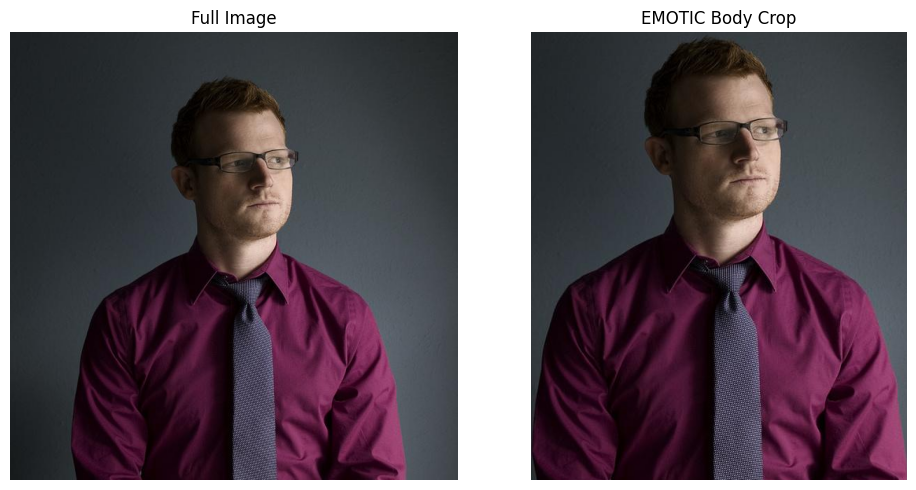

In [40]:
# === 1. Build the image path and load the image ===
folder = sample['folder'][0]
filename = sample['filename'][0]

image_path = os.path.join("emotic", folder, filename)
print("Image path:", image_path)

img_bgr = cv2.imread(image_path)
if img_bgr is None:
    raise FileNotFoundError(f"Could not load image at {image_path}")

# OpenCV loads BGR, but matplotlib expects RGB
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
print("Full image shape (H, W, C):", img_rgb.shape)

# === 2. Get the EMOTIC body bounding box ===
# body_bbox is nested, so flatten it to [x1, y1, x2, y2]
bbox = np.array(person_data['body_bbox'][0]).reshape(-1)  # -> e.g. [86, 58, 564, 628]
x1, y1, x2, y2 = map(int, bbox[:4])
print("Body bbox:", x1, y1, x2, y2)

# Safety: clamp bbox to image bounds
h, w, _ = img_rgb.shape
x1 = max(0, min(x1, w - 1))
x2 = max(0, min(x2, w))
y1 = max(0, min(y1, h - 1))
y2 = max(0, min(y2, h))

# === 3. Crop the body region ===
crop = img_rgb[y1:y2, x1:x2]
print("Crop shape:", crop.shape)

# === 4. Visualize full image + crop ===
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title("Full Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(crop)
plt.title("EMOTIC Body Crop")
plt.axis("off")

plt.tight_layout()
plt.show()

# Test extracting facial regions